In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
def euler6tomarix4d(a_R):
    """ Convert 6D vector containing angles to 4D rotation matrix

    a_R: tf.tensor/np.ndarray
        Vector of shape (6,)

    Returns
    -------
    R: tf.tensor/np.ndarray
        4x4 Rotation matrix corresponding to these 6 angles of rotations
    """
    xy, xz, xw, yz, yw, zw = a_R

    cxy = np.cos(xy)
    cxz = np.cos(xz)
    cxw = np.cos(xw)
    cyz = np.cos(yz)
    cyw = np.cos(yw)
    czw = np.cos(zw)

    sxy = np.sin(xy)
    sxz = np.sin(xz)
    sxw = np.sin(xw)
    syz = np.sin(yz)
    syw = np.sin(yw)
    szw = np.sin(zw)

    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = np.array([[  cxy,  -sxy, 0.0, 0.0],
              [  sxy,   cxy, 0.0, 0.0],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])

    Rxz = np.array([[  cxz, 0.0,  -sxz, 0.0],
               [0.0, 1.0, 0.0, 0.0],
               [  sxz, 0.0,   cxz, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

    Rxw = np.array([[  cxw, 0.0, 0.0,  -sxw],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0],
               [  sxw, 0.0, 0.0,  cxw]])

    Ryz = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0,   cyz,  -syz, 0.0],
               [0.0,   syz,   cyz, 0.0],
               [0.0, 0.0, 0.0, 1.0]])

    Ryw = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0,   cyw, 0.0,  -syw],
               [0.0, 0.0, 1.0, 0.0],
               [0.0,   syw, 0.0,  cyw]])

    Rzw = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0],
               [0.0, 0.0,   czw,  -szw],
               [0.0, 0.0,   szw,  czw]])

    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    return R

In [3]:
df = pd.read_csv("../results/alignment/loss.csv")
df['seed'] = df.seed.astype(int)
df['good_conv'] = (df['final_loss'] < 0.1)

In [4]:
n_runs = 100
trajectories = {}
critical_points = np.zeros([n_runs, 6])
for i in range(n_runs):
    trajectories[i] = np.load(f'../results/alignment/trajectories/{i}.npy')
    critical_points[i, :] = trajectories[i][-1, :]

In [5]:
def rotations_equal(R1, R2):
    tol = 1e-8
    
    R1 = list(map(lambda x: x%(2*np.pi), R1))
    R2 = list(map(lambda x: x%(2*np.pi), R2))
    
    r = lambda i: R1[i]+R2[i]-2*(np.allclose(np.abs(R1[i]-R2[i])%np.pi, 0.0, atol=tol) or np.allclose(np.abs(R1[i]-R2[i])%np.pi, np.pi, atol=tol))*R2[i] 

    rd = lambda i, j: (r(i)+r(j))%(2*np.pi) if not np.allclose((r(i)+r(j))%(2*np.pi), 2*np.pi, atol=tol) else \
                      (2*np.pi)%(r(i)+r(j))

    return np.allclose((rd(0, 5) + rd(1, 4) + rd(2, 3))%(3*np.round(np.pi,2)),     0.0, atol=tol) or \
           np.allclose((rd(0, 5) + rd(1, 4) + rd(2, 3))%(3*np.round(np.pi,2)), 3*np.pi, atol=tol)

In [6]:
def rotations_equal(R1, R2, return_m=False):
    M1 = euler6tomarix4d(R1)
    M2 = euler6tomarix4d(R2)
    if return_m:
        return M1, M2
    cond = (np.allclose(M1, M2) | np.allclose(M1, -M2))
    return cond

In [7]:
def create_unique_angle(point):
    """Constructs the equivalent 6d vector with all positive components
    such that their sum is minimum"""
    point = [x % (2 * np.pi) for x in point]
    return point

In [8]:
a = [4.268, 5.68,  3.375, 3.562, 0.445, 6.004]
print(f"{np.around(a,3)}")
print(sum(a))

[4.268 5.68  3.375 3.562 0.445 6.004]
23.334000000000003


In [9]:
b = create_unique_angle(a)
print(f"{np.around(b,3)}")
print(sum(b))

[4.268 5.68  3.375 3.562 0.445 6.004]
23.334000000000003


In [10]:
c = b.copy()
c[0] = 0
c[5] += b[0]

In [11]:
print(f"{np.around(a,3)}")
print(f"{np.around(b,3)}")
print(f"{np.around(c,3)}")
print(rotations_equal(a,b))
print(rotations_equal(a,c))
print(rotations_equal(b,c))

[4.268 5.68  3.375 3.562 0.445 6.004]
[4.268 5.68  3.375 3.562 0.445 6.004]
[ 0.     5.68   3.375  3.562  0.445 10.272]
True
False
False


In [13]:
df

,seed,final_loss,good_conv
0,0,1.804267,False
1,1,0.002206,True
2,2,0.002551,True
3,3,1.813860,False
4,4,1.805387,False
...,...,...,...
95,95,0.002384,True
96,96,0.002349,True
97,97,1.808804,False
98,98,0.002554,True


In [14]:
a = critical_points[1, :]
a

array([7.46021406, 2.58905189, 5.9320024 , 3.06165002, 2.56025736,
       3.82164765])

In [15]:
b = critical_points[2, :]
b

array([1.17798222, 5.7311303 , 3.49258011, 6.36339684, 5.70202671,
       3.82134471])

In [16]:
c = create_unique_angle(a)
np.array(c)

array([1.17702875, 2.58905189, 5.9320024 , 3.06165002, 2.56025736,
       3.82164765])

In [17]:
d = create_unique_angle(b)
np.array(d)

array([1.17798222, 5.7311303 , 3.49258011, 0.08021153, 5.70202671,
       3.82134471])

In [19]:
funs = [idd, opp, add_pi, opp_pi]
list_comb = []
it = [0, 0, 0, 0, 0, 0, 0]
while it[0] == 0:
    e = np.empty_like(a)
    for i in range(6):
        e[i] = funs[it[i + 1]](a[i])
    if rotations_equal(a, e):
        list_comb.append(it[1:])
    it[-1] += 1
    for i in range(6, -1, -1):
        if it[i] == 4:
            it[i] = 0
            it[i-1] += 1
list_comb

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 2, 3, 2],
 [0, 0, 2, 0, 3, 2],
 [0, 0, 2, 2, 0, 0],
 [0, 2, 1, 1, 2, 0],
 [0, 2, 1, 3, 1, 2],
 [0, 2, 3, 1, 1, 2],
 [0, 2, 3, 3, 2, 0],
 [2, 1, 1, 1, 1, 2],
 [2, 1, 1, 3, 2, 0],
 [2, 1, 3, 1, 2, 0],
 [2, 1, 3, 3, 1, 2],
 [2, 3, 0, 0, 3, 2],
 [2, 3, 0, 2, 0, 0],
 [2, 3, 2, 0, 0, 0],
 [2, 3, 2, 2, 3, 2]]

In [20]:
def create_unique_angle(point):
    """Constructs the equivalent 6d vector with all positive components
    such that their sum is minimum"""
    LIST_FUN = [idd, opp, add_pi, opp_pi]
    LIST_EQUIV = [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 3, 2],
        [0, 0, 2, 0, 3, 2],
        [0, 0, 2, 2, 0, 0],
        [0, 2, 1, 1, 2, 0],
        [0, 2, 1, 3, 1, 2],
        [0, 2, 3, 1, 1, 2],
        [0, 2, 3, 3, 2, 0],
        [2, 1, 1, 1, 1, 2],
        [2, 1, 1, 3, 2, 0],
        [2, 1, 3, 1, 2, 0],
        [2, 1, 3, 3, 1, 2],
        [2, 3, 0, 0, 3, 2],
        [2, 3, 0, 2, 0, 0],
        [2, 3, 2, 0, 0, 0],
        [2, 3, 2, 2, 3, 2]
    ]
    point = [x % (2 * np.pi) for x in point]
    best_sum = np.inf
    best_point = None
    for eq in LIST_EQUIV:
        x = np.zeros_like(point)
        for i in range(6):
            x[i] = LIST_FUN[eq[i]](point[i])
            if x[i] < 0:
                x[i] += 2 * np.pi
            elif x[i] > (2 * np.pi):
                x[i] -= 2 * np.pi
        if sum(x) == best_sum:
            # Ties are solved by smaller first components
            for i in range(6):
                if x[i] == best_point[i]:
                    continue
                elif x[i] < best_point[i]:
                    best_point = x
                    break
                else:
                    break
        elif sum(x) < best_sum:
            best_point = x
            best_sum = sum(x)
    return best_point

In [21]:
rotations_equal([0,0,0,0,0,0], [np.pi,0,0,0,0,np.pi], return_m=True)

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([[-1.0000000e+00, -1.2246468e-16,  0.0000000e+00,  0.0000000e+00],
        [ 1.2246468e-16, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00, -1.0000000e+00, -1.2246468e-16],
        [ 0.0000000e+00,  0.0000000e+00,  1.2246468e-16, -1.0000000e+00]]))

[0.66253589 0.22295879 0.05092455 0.04399491 0.01360243 0.00598343]


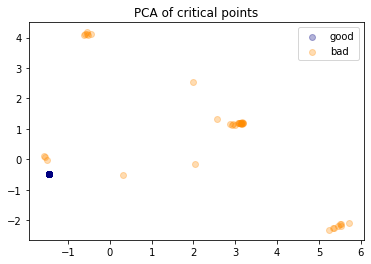

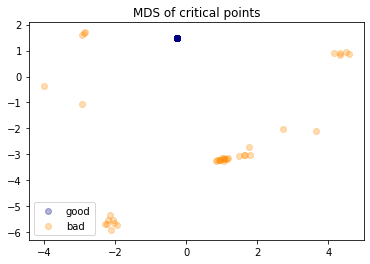

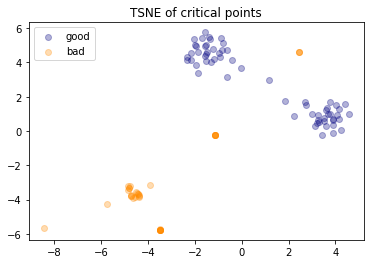